Loaded 560 records


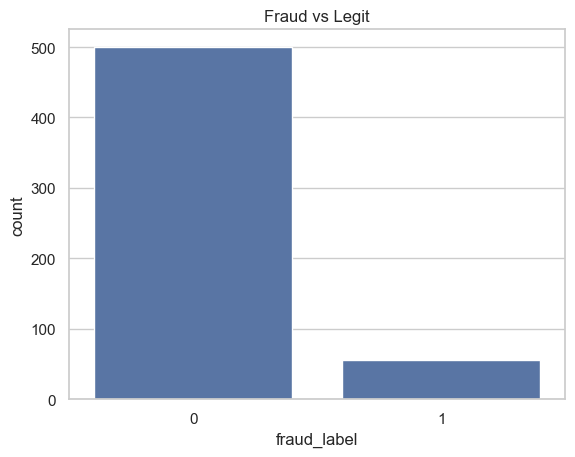

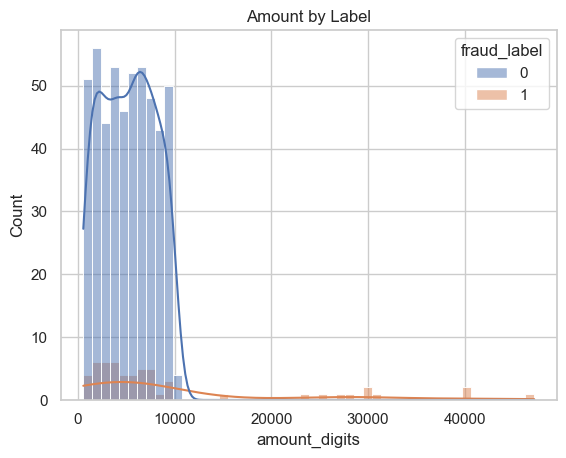

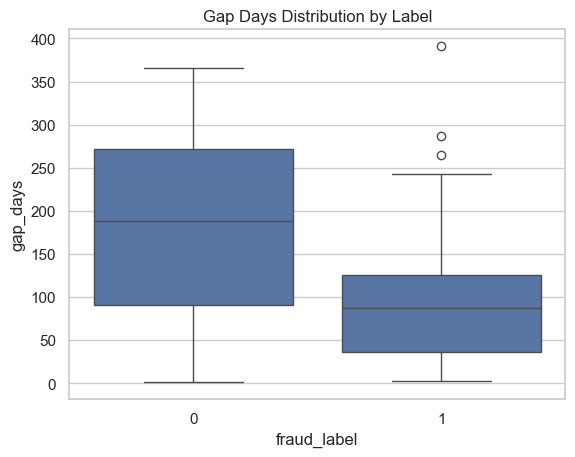

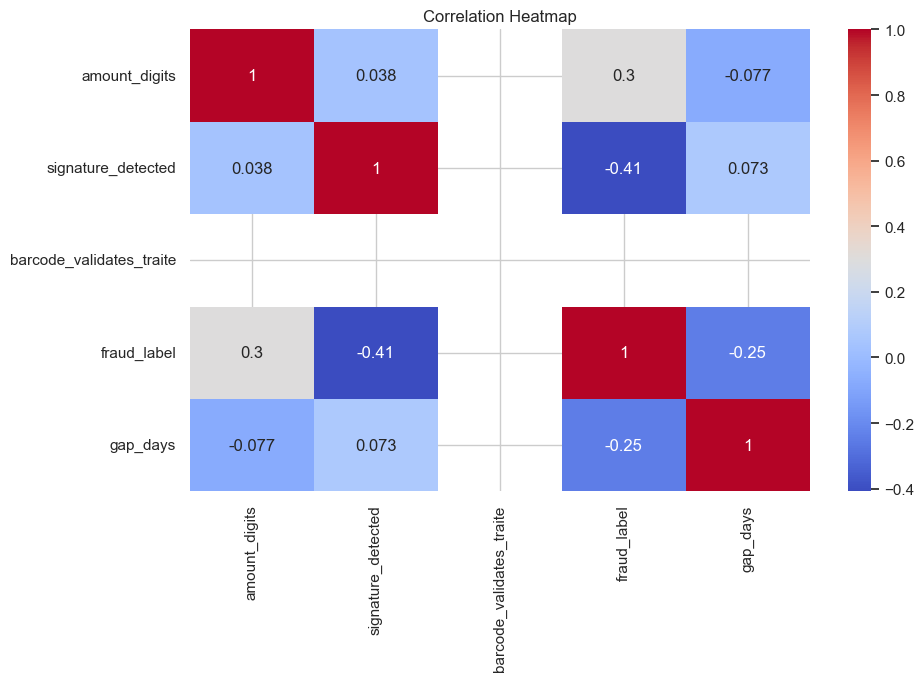

Resampled training set: 520 entries, 120 frauds


C:\Users\mghir\Desktop\layoutMl\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [05:36:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


ROC AUC: 0.8809090909090909
Best threshold by F1: 0.667


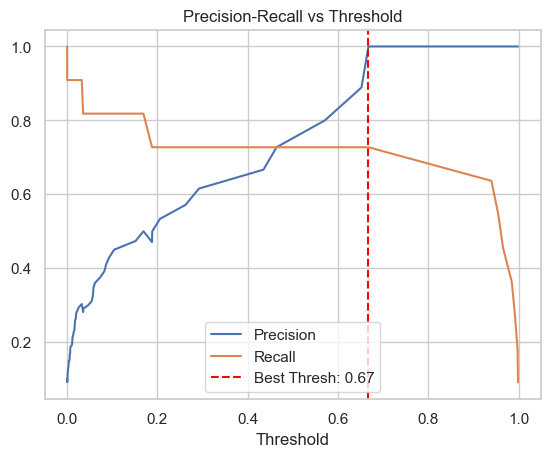

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       100
           1       1.00      0.64      0.78        11

    accuracy                           0.96       111
   macro avg       0.98      0.82      0.88       111
weighted avg       0.97      0.96      0.96       111



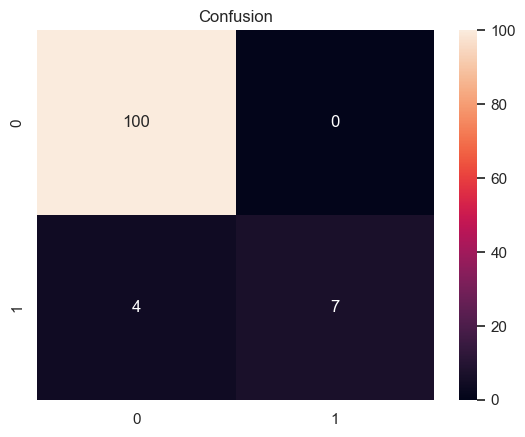

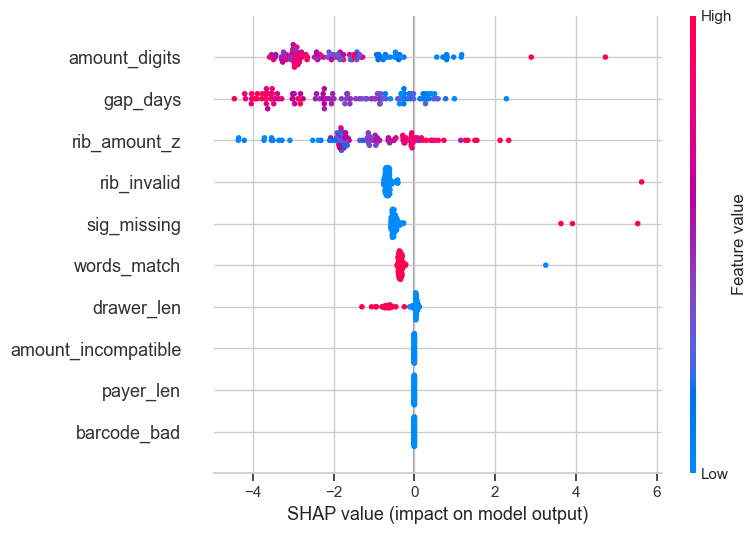

--- Testing Legit Example ---
Derived features: {'date_created': Timestamp('2025-01-19 00:00:00'), 'date_due': Timestamp('2025-05-26 00:00:00'), 'amount_digits': 7374.015, 'amount_words': 'sept mille trois cent soixante-quatorze dinars zéro zéro un cinq', 'signature_detected': True, 'barcode_validates_traite': True, 'rib': '72791940961055661374', 'payer_name_address': 'boulevard Gabriel Guérin 30838 Allainboeuf', 'drawer_name': 'René Schmitt'}
Prediction: {'fraud_score': 0.468, 'fraud_label': False}
--- Testing Fraud Example ---
Derived features: {'date_created': Timestamp('2025-01-24 00:00:00'), 'date_due': Timestamp('2025-04-21 00:00:00'), 'amount_digits': 2944.271, 'amount_words': 'deux mille neuf cent quarante-quatre dinars zéro deux sept un', 'signature_detected': True, 'barcode_validates_traite': True, 'rib': '73471566277689627059', 'payer_name_address': '6, avenue de Gillet 41549 Grégoire', 'drawer_name': 'Éric Ramos'}
Prediction: {'fraud_score': 0.998, 'fraud_label': True}
--- 

InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 5 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

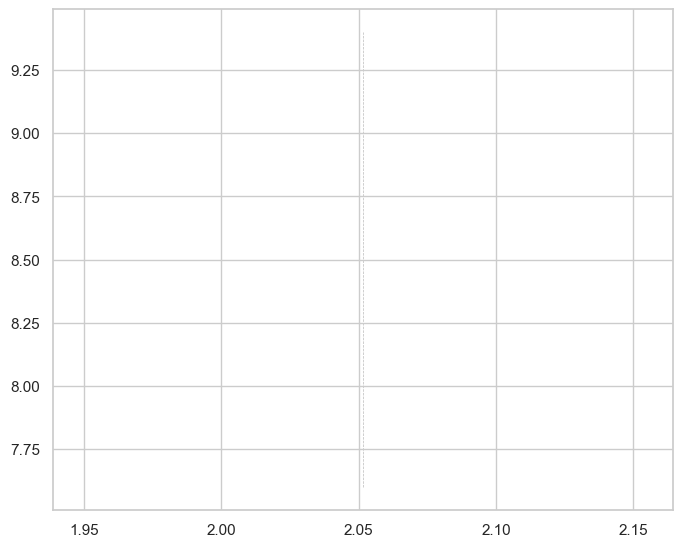

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap
import xgboost as xgb
import tensorflow as tf
from num2words import num2words
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, confusion_matrix
from imblearn.over_sampling import SMOTE

sns.set(style='whitegrid')

engine = 'sqlite:///drafts1.db'
df = pd.read_sql('SELECT * FROM drafts', engine)
print(f"Loaded {len(df)} records")
for col in ['bank','place_created','drawer_name','payer_name_address','amount_words']:
    df[col] = df[col].astype(str).str.strip()
for col in ['date_created','date_due']:
    df[col] = pd.to_datetime(df[col], errors='coerce')
df['amount_digits'] = pd.to_numeric(df['amount_digits'], errors='coerce')
df = df.dropna(subset=['amount_digits','date_created','date_due','rib'])
df['gap_days'] = (df['date_due'] - df['date_created']).dt.days
df['fraud_label'] = df['fraud_label'].astype(int)
df = df.drop_duplicates()
df = df[df['gap_days'] >= 0]
# Fraud count
sns.countplot(x='fraud_label', data=df)
plt.title('Fraud vs Legit'); plt.show()

sns.histplot(df, x='amount_digits', hue='fraud_label', bins=50, kde=True)
plt.title('Amount by Label'); plt.show()

sns.boxplot(x='fraud_label', y='gap_days', data=df)
plt.title('Gap Days Distribution by Label'); plt.show()

plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap'); plt.show()
rib_stats = df.groupby('rib')['amount_digits'].agg(mean_amt='mean', std_amt='std', count='count')
pop_mean, pop_std = df['amount_digits'].mean(), df['amount_digits'].std()

from num2words import num2words

def amount_to_words_fr(x): return num2words(x, lang='fr').replace('virgule','dinars zéro')

def is_valid_rib(v):
    s = ''.join(filter(str.isdigit, str(v)))
    if len(s) != 20: return False
    try:
        n = int(s[:-2] + '00'); chk = 97 - (n % 97)
        return chk == int(s[-2:])
    except: return False
fdf = df.copy()
fdf['words_match'] = (fdf['amount_words'] == fdf['amount_digits'].apply(amount_to_words_fr)).astype(int)
fdf['sig_missing'] = (~fdf['signature_detected']).astype(int)
fdf['barcode_bad'] = (~fdf['barcode_validates_traite']).astype(int)
fdf['rib_invalid'] = (~fdf['rib'].apply(is_valid_rib)).astype(int)
fdf['payer_len'] = fdf['payer_name_address'].str.len()>=20
fdf['drawer_len'] = fdf['drawer_name'].str.len()>=20

def compute_z(row):
    rib = row['rib']
    amt = row['amount_digits']
    if rib in rib_stats.index and rib_stats.at[rib,'count'] >= 5:
        mu = rib_stats.at[rib,'mean_amt']; sigma = rib_stats.at[rib,'std_amt']
    else:
        mu, sigma = pop_mean, pop_std
    return (amt - mu) / sigma if sigma > 0 else 0

fdf['rib_amount_z'] = fdf.apply(compute_z, axis=1)
fdf['amount_incompatible'] = (fdf['rib_amount_z'].abs() > 3).astype(int)

features = ['amount_digits','gap_days','words_match','sig_missing','barcode_bad','rib_invalid','payer_len','drawer_len','rib_amount_z','amount_incompatible']
X = fdf[features].values
y = fdf['fraud_label'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)
scale_pos = np.bincount(y_train)[0] / np.bincount(y_train)[1]

sm = SMOTE(sampling_strategy=0.3,random_state=42)
X_res, y_res = sm.fit_resample(X_train,y_train)
print(f"Resampled training set: {len(y_res)} entries, {y_res.sum()} frauds")
model = xgb.XGBClassifier(
    scale_pos_weight=scale_pos,
    max_depth=5,
    learning_rate=0.1,
    n_estimators=200,
    use_label_encoder=False,
    eval_metric='logloss',
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_res,y_res)
joblib.dump(model,'xgb_model56.pkl')
probs = model.predict_proba(X_test)[:,1]
print("ROC AUC:",roc_auc_score(y_test,probs))

prec,rec,thr = precision_recall_curve(y_test,probs)
f1_scores = 2*prec*rec/(prec+rec+1e-6)
best_idx = np.argmax(f1_scores)
threshold = thr[best_idx]
print(f"Best threshold by F1: {threshold:.3f}")

plt.plot(thr,prec[:-1],label='Precision'); plt.plot(thr,rec[:-1],label='Recall')
plt.axvline(threshold, color='red', linestyle='--', label=f'Best Thresh: {threshold:.2f}')
plt.xlabel('Threshold');plt.legend();plt.title('Precision-Recall vs Threshold');plt.show()

preds = (probs>threshold).astype(int)
print(classification_report(y_test,preds))
sns.heatmap(confusion_matrix(y_test,preds),annot=True,fmt='d');plt.title('Confusion');plt.show()
explainer = shap.TreeExplainer(model)
shap_vals = explainer.shap_values(X_test)
shap.summary_plot(shap_vals,X_test,feature_names=features)
import pandas as pd
import joblib
_xgb = joblib.load('xgb_model56.pkl')
# def predict_xgb(raw_input):
#     gap = (pd.to_datetime(raw_input['date_due'])-pd.to_datetime(raw_input['date_created'])).days
#     feat = [
#         raw_input['amount_digits'],gap,
#         int(raw_input['amount_words']==amount_to_words_fr(raw_input['amount_digits'])),
#         int(not raw_input['signature_detected']),
#         int(not raw_input['barcode_validates_traite']),
#         int(not is_valid_rib(raw_input['rib'])),
#         len(raw_input['payer_name_address']),
#         len(raw_input['drawer_name'])
#     ]
#     rib_amt = raw_input['amount_digits']
#     rib = raw_input['rib']
#     if rib in rib_stats.index and rib_stats.at[rib,'count'] >= 5:
#         mu = rib_stats.at[rib,'mean_amt']; sigma = rib_stats.at[rib,'std_amt']
#     else:
#         mu, sigma = pop_mean, pop_std
#     zscore = (rib_amt - mu) / sigma if sigma > 0 else 0
#     feat += [zscore, int(abs(zscore) > 3)]
#     prob = _xgb.predict_proba([feat])[0][1]
#     return {'fraud_score':round(prob,3),'fraud_label': prob>threshold}
rib_stats = df.groupby('rib')['amount_digits'].agg(mean_amt='mean', std_amt='std', count='count')
pop_mean, pop_std = df['amount_digits'].mean(), df['amount_digits'].std()

def predict_xgb(raw_input):
    gap = (pd.to_datetime(raw_input['date_due'])-pd.to_datetime(raw_input['date_created'])).days
    feat = [
        raw_input['amount_digits'],gap,
        int(raw_input['amount_words']==amount_to_words_fr(raw_input['amount_digits'])),
        int(not raw_input['signature_detected']),
        int(not raw_input['barcode_validates_traite']),
        int(not is_valid_rib(raw_input['rib'])),
        len(raw_input['payer_name_address']),
        len(raw_input['drawer_name'])
    ]
    rib_amt = raw_input['amount_digits']
    rib = raw_input['rib']
    if rib in rib_stats.index and rib_stats.at[rib,'count'] >= 5:
        mu = rib_stats.at[rib,'mean_amt']; sigma = rib_stats.at[rib,'std_amt']
    else:
        mu, sigma = pop_mean, pop_std
    zscore = (rib_amt - mu) / sigma if sigma > 0 else 0
    feat += [zscore, int(abs(zscore) > 3)]
    prob = _xgb.predict_proba([feat])[0][1]
    return {'fraud_score':round(prob,3),'fraud_label': prob>threshold}
import shap
explainer = shap.TreeExplainer(_xgb)
def explain_prediction(raw_input, label_text, return_vector=False):
    # --- Feature extraction ---
    gap = (pd.to_datetime(raw_input['date_due']) - pd.to_datetime(raw_input['date_created'])).days
    feat = [
        raw_input['amount_digits'], gap,
        int(raw_input['amount_words'] == amount_to_words_fr(raw_input['amount_digits'])),
        int(not raw_input['signature_detected']),
        int(not raw_input['barcode_validates_traite']),
        int(not is_valid_rib(raw_input['rib'])),
        len(raw_input['payer_name_address']),
        len(raw_input['drawer_name'])
    ]
    
    # RIB stats-based features
    rib = raw_input['rib']
    amt = raw_input['amount_digits']
    if rib in rib_stats.index and rib_stats.at[rib, 'count'] >= 5:
        mu = rib_stats.at[rib, 'mean_amt']
        sigma = rib_stats.at[rib, 'std_amt']
    else:
        mu, sigma = pop_mean, pop_std

    z = (amt - mu) / sigma if sigma > 0 else 0
    incompatible = int(abs(z) > 3) if rib in rib_stats.index and rib_stats.at[rib, 'count'] >= 5 else 0
    feat += [z, incompatible]

    # --- Prediction ---
    prob = _xgb.predict_proba([feat])[0][1]
    shap_vals = explainer.shap_values([feat])[0]

    print(f"--- {label_text} Prediction ---")
    print(f"Probability: {prob:.3f} -> Label: {prob > threshold}")

    # --- SHAP Explanation ---
    reasons_for_fraud = []
    reasons_against_fraud = []

    for name, val, sv in zip(features, feat, shap_vals):
        if sv > 0.5:
            if name == "sig_missing" and val == 1:
                reasons_for_fraud.append("Signature is not present, which often indicates fraud.")
            elif name == "words_match" and val == 0:
                reasons_for_fraud.append("Amount in words does not match amount in digits.")
            elif name == "rib_invalid" and val == 1:
                reasons_for_fraud.append("RIB format appears invalid.")
            elif name == "rib_amount_z" and abs(val) > 2:
                reasons_for_fraud.append("Amount deviates significantly from historical RIB norms.")
            elif name == "amount_incompatible" and val == 1:
                reasons_for_fraud.append("RIB and amount are statistically incompatible.")
        elif sv < -0.5:
            if name == "sig_missing" and val == 0:
                reasons_against_fraud.append("Signature is present, which is common in valid drafts.")
            elif name == "words_match" and val == 1:
                reasons_against_fraud.append("Digit and written amounts match.")
            elif name == "amount_digits":
                reasons_against_fraud.append("Transaction amount is within typical range.")
            elif name == "gap_days":
                reasons_against_fraud.append("Due date gap is reasonable.")

    # Print readable explanation
    print("\n🚨 Reasons suggesting fraud:")
    if reasons_for_fraud:
        for r in reasons_for_fraud:
            print(f" - {r}")
    else:
        print(" - None")

    print("\n✅ Reasons against fraud:")
    if reasons_against_fraud:
        for r in reasons_against_fraud:
            print(f" - {r}")
    else:
        print(" - None")

    print("\n🧠 Model interpretation:")
    if prob > threshold:
        print("→ Likely fraudulent due to red flags above.")
    else:
        print("→ Likely legitimate based on current indicators.")

    if return_vector:
        return feat



legit = df[df.fraud_label == 0].sample(1).iloc[0]   # no seed
fraud = df[df.fraud_label == 1].sample(1).iloc[0]
def to_raw(r):
    return dict(
        date_created=r.date_created, date_due=r.date_due,
        amount_digits=float(r.amount_digits), amount_words=r.amount_words,
        signature_detected=bool(r.signature_detected),
        barcode_validates_traite=bool(r.barcode_validates_traite),
        rib=r.rib, payer_name_address=r.payer_name_address, drawer_name=r.drawer_name
    )
print("--- Testing Legit Example ---")
print("Derived features:", to_raw(legit))
print("Prediction:", predict_xgb(to_raw(legit)))

print("--- Testing Fraud Example ---")
print("Derived features:", to_raw(fraud))
print("Prediction:", predict_xgb(to_raw(fraud)))

explain_prediction(to_raw(legit), 'Legit')
explain_prediction(to_raw(fraud), 'Fraud')
import shap
# Choose the feature vector for the fraud example
feat_vec = explain_prediction(to_raw(fraud), 'Fraud', return_vector=True)
# Waterfall
shap.plots.waterfall(explainer(tf.convert_to_tensor([feat_vec]))[0])
shap.summary_plot(explainer(tf.convert_to_tensor([feat_vec]))[0])



test1 = {
    'traite_num': "010687580474",
    'bank': 'biat',
    'amount_digits': 6776.383,
    'amount_words': 'six mille sept cent soixante-seize dinars zéro trois huit trois',
    'rib': '01050093110000158536',  # 20-digit valid RIB (example)
    'signature_detected': False,
    'barcode_validates_traite': False,
    'date_created': '2025-01-03',
    'date_due': '2025-05-26',
    'place_created': 'Tunis',
    'drawer_name': 'Client Bravo bravo bravo',

    'payer_name_address': 'Entreprise Alpha, 23 rue de l\'Église',
}
print("Test1 Prediction:", predict_xgb(test1))
print(explain_prediction(test1,"test1"))
    
# Custom Test 2: Suspicious Draft
test2 = {
        'date_created': '2023-12-01',
        'date_due': '2024-12-01',
        'amount_digits': 30000.00,
        'amount_words': 'trente mille dinars zéro',
        'signature_detected': False,
        'barcode_validates_traite': False,
        'rib': '98765432109876543210',  # invalid
        'payer_name_address': 'M',
        'drawer_name': 'Hc'
    }
print("Test2 Prediction:", predict_xgb(test2))
csv_line = "298196678410,Charles et Fils,6776.383,six mille sept cent soixante-seize dinars zéro trois huit trois,19431142626551104724,1,1,2025-01-03,2025-05-26,Pineauboeuf,Paul Duhamel,\"24, rue de Dumas 94621 Saint Alexandre\",0"
    
# Parse CSV
o = csv_line.split(',')
raw_test = {
        'traite_num': o[0],
        'bank': o[1],
        'amount_digits': float(o[2]),
        'amount_words': o[3],
        'rib': o[4],
        'signature_detected': bool(int(o[5])),
        'barcode_validates_traite': bool(int(o[6])),
        'date_created': o[7],
        'date_due': o[8],
        'place_created': o[9],
        'drawer_name': o[10],
        'payer_name_address': o[11].strip('"'),
        # fraud label omitted for testing
    }
test4={
    "amount_digits": 6500,
    "date_created": "2025-05-13",
    "date_due":     "2025-10-22",
    "amount_words": "six mille cinq cents",
    "signature_detected": True,
    "barcode_validates_traite": True,
    "rib": "08024011071000504494",
    "payer_name_address": "Tireur -tJ! Slc SmaJha",  # or wherever that came from
    "drawer_name": "Tireur -tJ! Slc SmaJha"
}

print(predict_xgb(test4))
print("Raw CSV Parsed Input:", raw_test)
print("Prediction and Explanation:")
explain_prediction(test4, 'User Provided Row')